# Predictive elicitation

The examples below can be executed from within this page thanks to embedded integration with Binder via Thebe.
Click on the button below and start playing with PreliZ right from your browser or open this notebook or Binder directly [![badge](https://img.shields.io/badge/launch-binder-579ACA.svg?logo=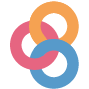)](https://mybinder.org/v2/gh/arviz-devs/arviz_sandbox/main?urlpath=git-pull%3Frepo%3Dhttps%253A%252F%252Fgithub.com%252Farviz-devs%252Fpreliz%26urlpath%3Dtree%252Fpreliz%252Fdocs%252Fexamples%252Fobserved_space_examples.ipynb%26branch%3Dmain)


:::{thebe-button}
:::

In [1]:
# latest PreliZ might not be installed
import sys

!{sys.executable} -m pip install preliz@git+https://github.com/arviz-devs/preliz.git

In [1]:
import arviz as az
import preliz as pz
import numpy as np

In [2]:
az.style.use("arviz-white")

Predictive elicitation refers to the elicitation of priors by making evaluations on the observed space, instead of a the parameters space. The advantage of the former is that generally it is easier to thing about observation than parameters, specially for domain experts. If you are a Forest engineer, you may be more familiar with the expected rate of wildfires in an area than with the `rho` parameter of a model.

Currently PreliZ provides two functions for predictive elicitation. Most of the future development of PreliZ will be focused on improving these tool and providing other tools for predictive elicitation.

(predictive_sliders)=

## Predictive sliders

This functions will automatically generate sliders for a function with makes easier to explore how the prior predictive distribution changes when we change the priors.

So suppose you already have a model, but you are unsure about the implications of its parameters. You can write it using PreliZ distributions and put it inside a function with the arguments being the parameters you want to explore.

In [3]:
x = np.linspace(0, 1, 100)

def a_preliz_model(a_mu, a_sigma, c_sigma=1):
    a = pz.Normal(a_mu, a_sigma).rvs()
    c = pz.Gamma(mu=2, sigma=c_sigma).rvs()
    b = pz.Normal(np.exp(a)*x, c).rvs()
    return b

By calling `predictive_sliders` you will get sliders with some default initial values and ranges for you to explore

In [4]:
pz.predictive_sliders(a_preliz_model)

interactive(children=(FloatSlider(value=0.0, continuous_update=False, description='a_mu (-inf, inf)', max=10.0…

(prior_predictive_assistant)=

## Prior predictive assistant

Now we will see a vert experimental tool called "prior predictive assistant" (ppa for short).

Suppose we have a very simple model here expressed using PyMC syntax (in the future we will be able to express the model using just PreliZ):

```python
with pm.Model() as model:
    a = pm.Normal("a", 0, 10)
    b = pm.HalfNormal("b", 10)
    y = pm.Normal("y", a, b, observed=data)
    pp_samples = pm.sample_prior_predictive(500)
```

`pp_samples` contains samples from the prior and prior predictive distributions. The `ppa` function takes those samples and the PyMC `model` and return a 3x3 panel of predictive distributions that the user can select by clicking on them. The user is expected to select those distributions that best match their domain knowledge (i.e. prior information and NOT the observed data they want to fit). Once the user has selected at least one distribution is has two options click on the `carry on` button to get a new subset of predictive distributions or click on the `return prior` button to get a prior that agrees with all the selected predictive distributions. Currently `ppa` is restricted to return prior on the same family as specified in the `model`, in this example the prior for `a` will always be `Normal` and the prior for b `HalfNormal`. We are currently exploring the possibility to return families different from those specified in the original model.


![ppa](ppa.gif)